# Data Preprocessing

### Augmentation

In [ ]:
# 최신버전 업그레이드
!pip install --upgrade albumentations

In [6]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from bs4 import BeautifulSoup
import torch

def generate_box(obj):
    xmin = float(obj.find("xmin").text)
    ymin = float(obj.find("ymin").text)
    xmax = float(obj.find("xmax").text)
    ymax = float(obj.find("ymax").text)

    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find("name").text == "with_mask":
        return 1
    elif obj.find("name").text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.float32)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target
    
def plot_image_from_output(img, annotation):
    img = img.permute(1, 2, 0)
    
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation["labels"][idx] == 0:
            rect = patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor="r", facecolor="none")
        elif annotation["labels"][idx] == 1:
            rect = patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor="g", facecolor="none")
        else:
            rect = patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor="orange", facecolor="none")
    
        ax.add_patch(rect)

    plt.show()
            


### Torchvision Transforms

In [9]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random

class TorchvisionMaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + "xml"
        img_path = os.path.join(self.path, file_image)

        if "test" in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)
        
        img = Image.open(img_path).convert("RGB")

        target = generate_target(label_path)

        start_t = time.time()
        if self.transform:
            img = self.transform(img)
            
        total_time = (time.time() - start_t)

        return img, target, total_time

In [12]:
torchvision_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor()
])

torchvision_dataset = TorchvisionMaskDataset(
    path="images/",
    transform=torchvision_transform
)

transforms 적용 전


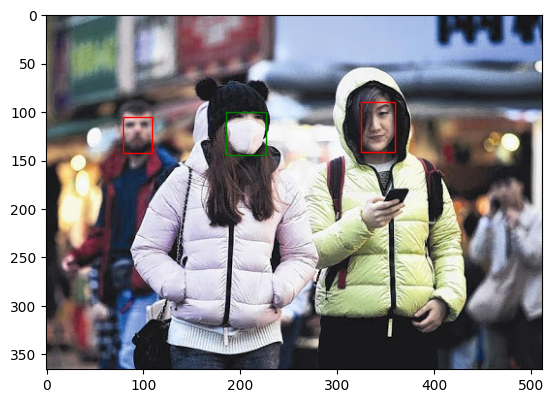

In [13]:
only_totensor = transforms.Compose([transforms.ToTensor()])

torchvision_dataset_no_transform = TorchvisionMaskDataset(
    path="images/",
    transform=only_totensor
)

img, annot, transform_time = torchvision_dataset_no_transform[0]
print("transforms 적용 전")
plot_image_from_output(img, annot)

transfomrs 적용 후


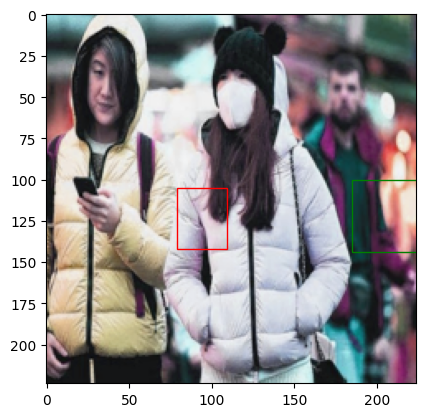

In [14]:
img, annot, transform_time = torchvision_dataset[0]

print("transfomrs 적용 후")
plot_image_from_output(img, annot)

In [15]:
total_time = 0
for i in range(100):
    sample, _, transform_time = torchvision_dataset[0]
    total_time += transform_time

print(f"torchvision time: {total_time*10} ms")

torchvision time: 3.18497896194458 ms


이미지 변환을 100번 수행하는 데 약 3ms가 소요된 것을 확인할 수 있다.

### Albumentations

In [33]:
class AlbumentationsDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + "xml"
        img_path = os.path.join(self.path, file_image)

        if "test" in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        start_t = time.time()

        if self.transform:
            augmented = self.transform(image=image)
            total_time = (time.time() - start_t)
            image = augmented["image"]

        return image, target, total_time


In [34]:
albumentations_transform = albumentations.Compose([
    albumentations.Resize(300, 300),
    albumentations.RandomCrop(224, 224),
    albumentations.ColorJitter(p=1),
    albumentations.HorizontalFlip(p=1),
    albumentations.pytorch.transforms.ToTensorV2()
])

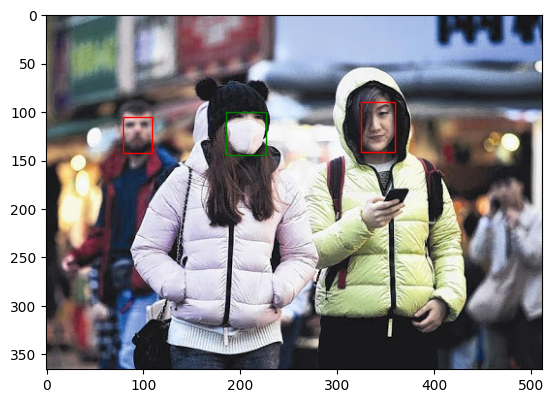

In [35]:
# 변경 전
img, annot, transform_time = torchvision_dataset_no_transform[0]
plot_image_from_output(img, annot)

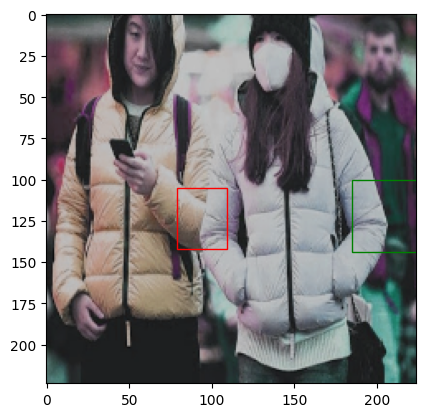

In [36]:
# 변경 후
albumentations_dataset = AlbumentationsDataset(
    path="images/",
    transform=albumentations_transform
)

img, annot, transform_time = albumentations_dataset[0]
plot_image_from_output(img, annot)

In [37]:
total_time = 0
for i in range(100):
    sample, _, transform_time = albumentations_dataset[0]
    total_time += transform_time

print(f"albumentations time/sample: {total_time*10}")

albumentations time/sample: 0.7424402236938477


이미지 변환을 100번 수행하는데 약 0.7ms 가 소요된 것을 확인할 수 있다. torchvision.transforms 와 비교했을 때 약 4배 정도 빠른 것을 알 수 있다.

### 확률 기반 Augmentation 조합

In [40]:
albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(300, 300), 
    albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                            albumentations.HorizontalFlip(p=1),
                            albumentations.RandomRotate90(p=1),
                            albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                            albumentations.MotionBlur(p=1),
                            albumentations.OpticalDistortion(p=1),
                            albumentations.GaussNoise(p=1)                 
    ], p=1),
    albumentations.pytorch.ToTensorV2()
])

아래는 albumentations_transform_oneof 를 이미지에 10번 적용한 결과이다.

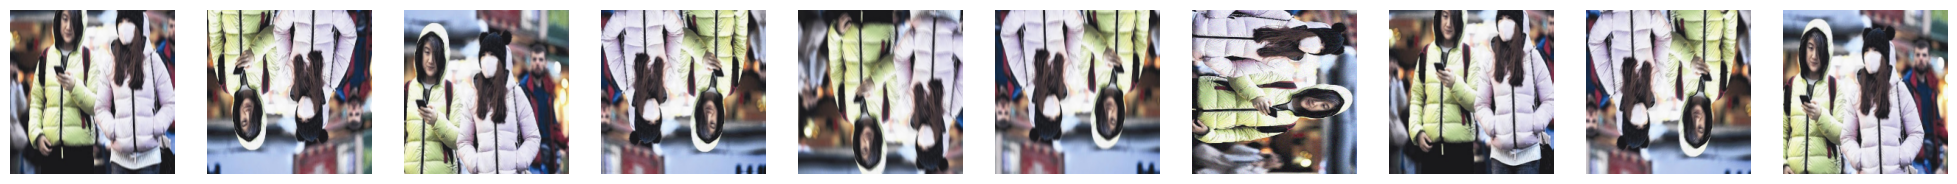

In [42]:
albumentations_dataset_oneof = AlbumentationsDataset(
    path="images/",
    transform=albumentations_transform_oneof
)

num_samples = 10
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
    ax[i].imshow(transforms.ToPILImage()(albumentations_dataset_oneof[0][0]))
    ax[i].axis("off")

### 바운딩 박스 Augmentation
객체 탐지 모델 구축에 사용되는 이미지에 대한 augmentation 진행 시, 이미지 변환 뿐만 아니라 그에 따른 바운딩 박스 변환도 함께 진행해주어야 한다. 앞에서 보았듯이 바운딩 박스를 함께 변환 시켜 주지 않으면 바운딩 박스가 엉뚱한 곳을 탐지하고 있기 때문에 모델 학습이 제대로 이뤄지지 않을 것이다. Albumentations에서 제공하는 Compose 함수에 있는 bbox_params 파라미터를 활용하면 바운딩 박스 augmentation이 가능하다.

In [43]:
class BboxAugmentationDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + "xml"
        img_path = os.path.join(self.path, file_image)

        if "test" in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        target = generate_target(label_path)

        if self.transform:
            transformed = self.transform(image=image, bboxes=target["boxes"], labels=target["labels"])
            image = transformed["image"]
            target = {"boxes": transformed["bboxes"], "labels": transformed["labels"]}

        return image, target


In [47]:
bbox_transform = albumentations.Compose(
    [
        albumentations.HorizontalFlip(p=1),
        albumentations.Rotate(p=1),
        albumentations.pytorch.transforms.ToTensorV2()
    ],
    bbox_params=albumentations.BboxParams(format="pascal_voc", label_fields=["labels"])
)

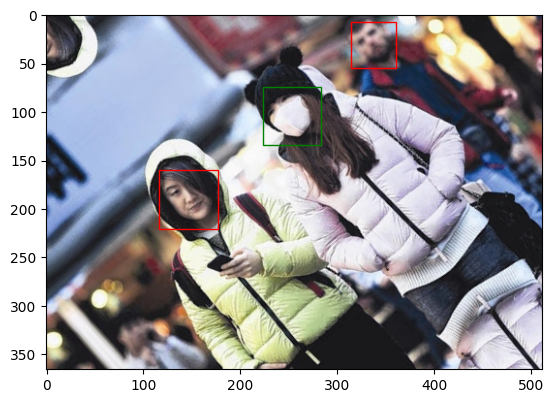

In [49]:
bbox_transform_dataset = BboxAugmentationDataset(
    path="images/",
    transform=bbox_transform
)

img, annot = bbox_transform_dataset[0]
plot_image_from_output(img, annot)

### 데이터 분리

In [50]:
print(len(os.listdir("annotations")))
print(len(os.listdir("images")))

853
853


In [ ]:
!mkdir test_images
!mkdir test_annotations

shutil 패키지를 활용해 170개의 이미지와 170개 좌표 파일들을 각각 test_images, test_annotations 디렉토리로 옮김

In [61]:
import random
random.seed(42)
idx = random.sample(range(853), 170)
print(len(idx))
print(idx[:10])

170
[654, 114, 25, 759, 281, 250, 228, 142, 754, 104]


In [63]:
import numpy as np
import shutil

for img in np.array(sorted(os.listdir("images")))[idx]:
    shutil.move("images/"+img, "test_images/"+img)

for annot in np.array(sorted(os.listdir("annotations")))[idx]:
    shutil.move("annotations/"+annot, "test_annotations/"+annot)

In [64]:
print(len(os.listdir("annotations")))
print(len(os.listdir("images")))
print(len(os.listdir("test_annotations")))
print(len(os.listdir("test_images")))

683
683
170
170


In [66]:
from tqdm import tqdm
from collections import Counter

def get_num_objects_for_each_class(dataset):
    total_labels = []
    
    for img, annot in tqdm(dataset, position=0, leave=True):
        total_labels += [ int(i) for i in annot["labels"] ]
    
    return Counter(total_labels)

train_data = BboxAugmentationDataset(
    path="images/"
)

test_data = BboxAugmentationDataset(
    path="test_images/"
)

train_objects = get_num_objects_for_each_class(train_data)
test_objects = get_num_objects_for_each_class(test_data)

print("\n train 데이터에 있는 객체", train_objects)
print("\n test 데이터에 있는 객체", test_objects)



100%|██████████| 170/170 [00:01<00:00, 130.23it/s]


 train 데이터에 있는 객체 Counter({1: 2637, 0: 612, 2: 101})

 test 데이터에 있는 객체 Counter({1: 595, 0: 105, 2: 22})
